
## Prepare the data

We begin by importing the necessary Python modules and loading some
data. The `MNE-Sample <sample-dataset>` dataset has some clear, large
blink artifacts, especially during the presentation of visual stimuli.


In [ ]:
import numpy as np

import mne
from mne.preprocessing import EOGRegression

data_path = mne.datasets.sample.data_path()
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_raw.fif"
raw = mne.io.read_raw_fif(raw_fname)
raw.pick(["eeg", "eog", "stim"])
raw.load_data()

# The regression technique works regardless of chosen reference. However, it is
# important to choose a reference before proceeding with the analysis.
raw.set_eeg_reference("average")

# Removing slow drifts makes for more stable regression coefficients. Make sure
# to apply the same filter to both EEG and EOG channels!
raw.filter(0.3, 40)

# make epochs
events = mne.find_events(raw)
event_id = {"visual/left": 3, "visual/right": 4}
epochs = mne.Epochs(raw, events, event_id=event_id, preload=True)

## Visualize the original data
Let's first look at the `~mne.Evoked` data (average across epochs) without
any corrections applied.



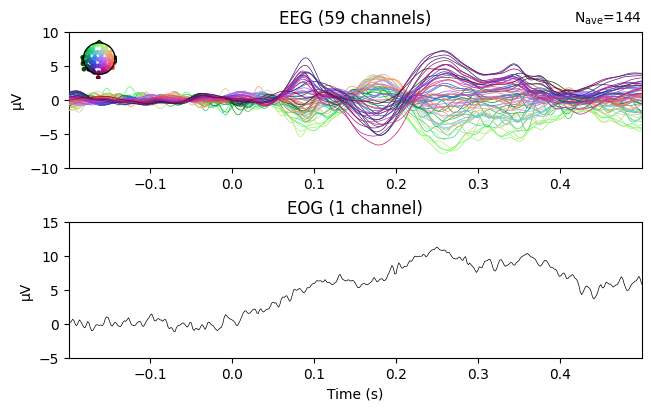

In [12]:
# we'll try to keep a consistent ylim across figures
plot_kwargs = dict(picks="all", ylim=dict(eeg=(-10, 10), eog=(-5, 15)))

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

We can see there is some EOG activity that is likely bleeding into the EEG
evoked response. At around 250ms this becomes especially noticeable. Let's
apply regression to subtract the EOG signal from the EEG signals to clean it
up.



## Compute and apply EOG regression
Now, we'll compare the evoked response before and after we regress out the
EOG signal. First, let's try plain regression, and then we'll explore more
advanced techniques.



No projector specified for this dataset. Please consider the method self.add_proj.


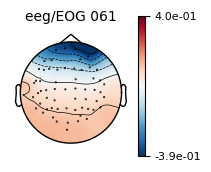

In [13]:
# Perform regression using the EOG sensor as independent variable and the EEG
# sensors as dependent variables.
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs)
fig = model_plain.plot(vlim=(None, 0.4))  # regression coefficients as topomap
fig.set_size_inches(3, 2)

The regression coefficients show the linear relationship between each EEG
sensor and the EOG sensor. Note that occipital sensors have a positive
relationship, as we set a common-average reference when we loaded the data
above.

Now we are ready to use these coefficients to subtract the EOG signal from
the EEG signals.



No projector specified for this dataset. Please consider the method self.add_proj.
Applying baseline correction (mode: mean)


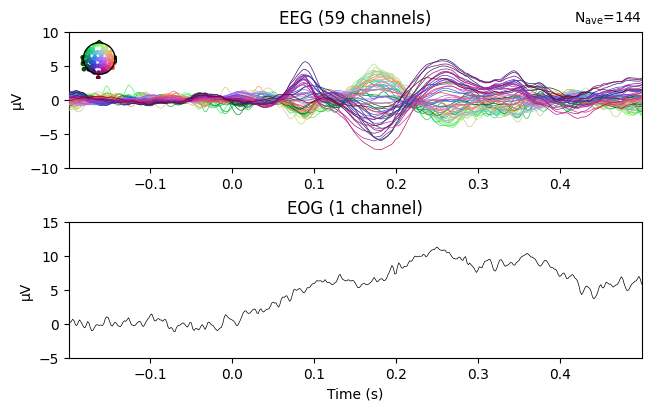

In [14]:
epochs_clean_plain = model_plain.apply(epochs)
# After regression, we should redo the baseline correction
epochs_clean_plain.apply_baseline()
# Show the evoked potential computed on the corrected data
fig = epochs_clean_plain.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

Regressing the EOG signal out of the EEG signals has reduced the peak around
250ms that was partly there because of eye artifacts.

In the `MNE-Sample dataset <sample-dataset>`, there are no segments of
data that are particularly unstable, so the basic form of regression produces
robust coefficients. However, this may not be the case in every dataset, so
let's explore some variations that may improve the estimation of the
regression coefficients.

One potential problem is that the EOG sensor does not only pick up eye
artifacts, but also a bit of EEG signal. This means we are prone to
overestimating the regression coefficients if the EOG sensors are placed too
close to the EEG sensors. However, there is a correction we can apply to
alleviate this.

## Subtract the evoked response from the epoch data before regression
Gratton et al. (1983) :footcite:`GrattonEtAl1983` suggest computing
regression coefficients on epoch data with the evoked response subtracted
out. The idea is that the EEG signal components relevant to the study are in
the evoked, so by removing them, mostly noise components will be left. Since
EOG artifacts are unlikely to be strictly time-locked to the stimulus onset,
enough EOG information will likely remain to be able to estimate robust
regression coefficients.



Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: STI 016, STI 003, STI 004, EOG 061, STI 005, STI 001, STI 015, STI 002, STI 006, STI 014
[done]
No projector specified for this dataset. Please consider the method self.add_proj.


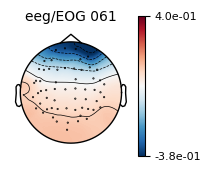

No projector specified for this dataset. Please consider the method self.add_proj.
Applying baseline correction (mode: mean)


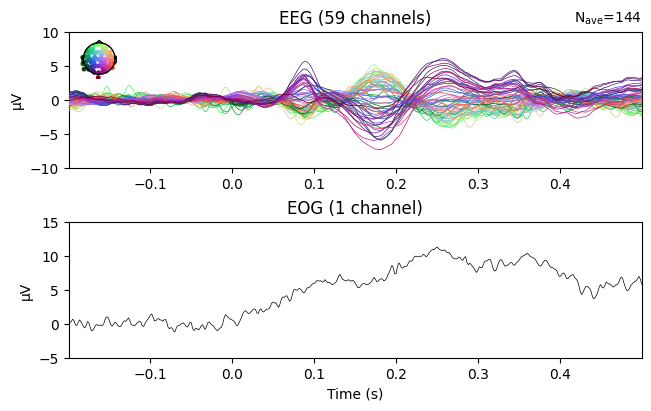

In [15]:
# create epochs with the evoked subtracted out
epochs_sub = epochs.copy().subtract_evoked()

# perform regression
model_sub = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs_sub)
fig = model_sub.plot(vlim=(None, 0.4))
fig.set_size_inches(3, 2)

# apply the regression coefficients to the original epochs
epochs_clean_sub = model_sub.apply(epochs).apply_baseline()
fig = epochs_clean_sub.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

We see that we obtain the same regression coefficients, even with the evoked
removed from the epochs.

## Create EOG evoked before regression
It is advantageous to estimate the regression coefficients on a piece of data
with lots of EOG activity. As EOG activity is typically much larger than EEG,
the EOG artifacts will dominate the signal and the regression coefficients
will reflect mostly the influence of the EOG. To amplify this effect, Croft &
Barry (2000) :footcite:`CroftBarry2000` suggest creating epochs based on
blink onsets and computing the evoked blink response. The averaging procedure
will suppress EEG signals that are not strictly time-locked with the blink
response. Ideally, one would create evokeds for both blinks and saccades, and
create two separate regression models. However, we will restrict ourselves to
just blink epochs, since MNE-Python contains an automated method for creating
those.

<div class="alert alert-info"><h4>Note</h4><p>This is very similar to the approach taken by `SSP
          <tut-artifact-ssp>`. The difference is that `SSP
          <tut-artifact-ssp>` estimates signal components that are maximally
          correlated with the artifact and removes any data along that
          component (thereby reducing the rank of the non-EOG data), whereas
          the regression approach uses the ongoing EOG signal to determine
          how much data to remove (thereby not necessarily reducing the rank
          of the non-EOG data). Generally, SSP tends to err on the side of
          removing too much data, eliminating artifacts and true brain
          signals alike, whereas regression will err on the side of not
          removing enough, leaving some artifact signals still present in the
          signal.</p></div>



Using EOG channel: EOG 061
EOG channel index for this subject is: [69]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 s)

Now detecting blinks and generating corresponding events
Found 46 significant peaks
Number of EOG events detected: 46
Not setting metadata
46 matching events found
No baseline correction applied
Using data from preloaded Raw for 46 events and 601 original time points ...
0 bad epochs dropped


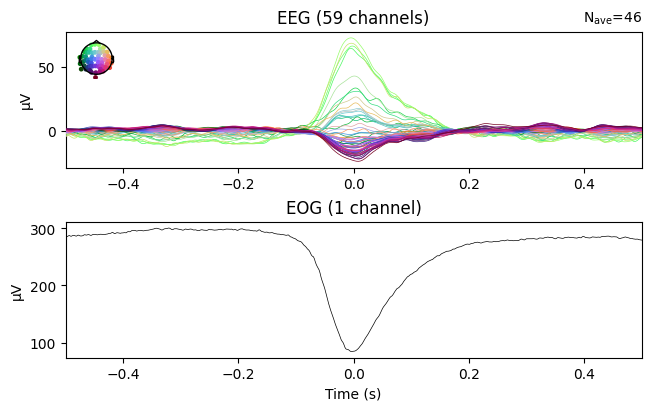

No projector specified for this dataset. Please consider the method self.add_proj.


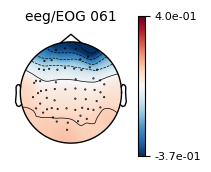

No projector specified for this dataset. Please consider the method self.add_proj.
Applying baseline correction (mode: mean)


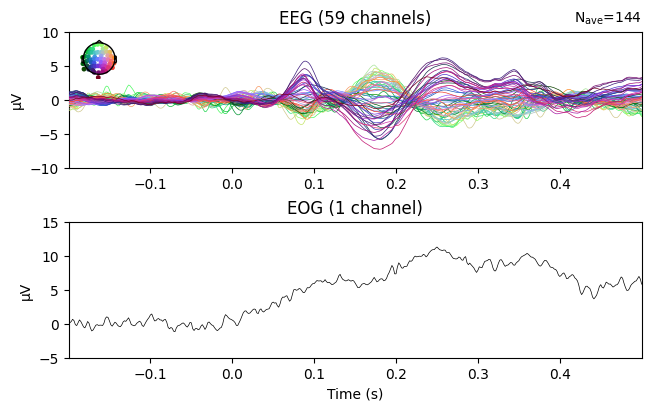

No projector specified for this dataset. Please consider the method self.add_proj.
Applying baseline correction (mode: mean)


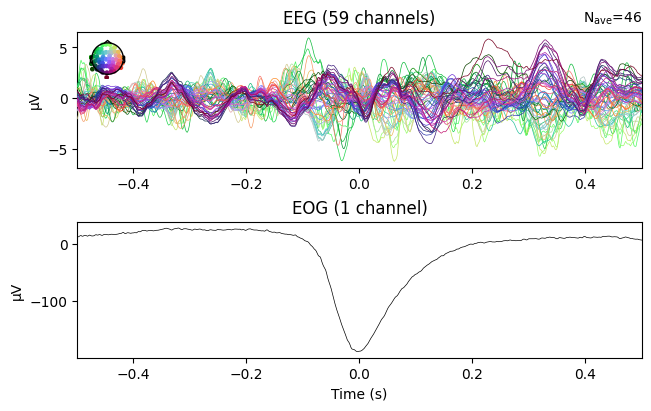

In [16]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw)
# We need to explicitly specify that we want to average the EOG channel too.
eog_evoked = eog_epochs.average("all")
eog_evoked.plot("all")
fig.set_size_inches(6, 6)

# perform regression on the evoked blink response
model_evoked = EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_evoked)
fig = model_evoked.plot(vlim=(None, 0.4))
fig.set_size_inches(3, 2)

# apply the regression coefficients to the original epochs
epochs_clean_evoked = model_evoked.apply(epochs).apply_baseline()
fig = epochs_clean_evoked.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

# for good measure, also show the effect on the blink evoked
eog_evoked_clean = model_evoked.apply(eog_evoked)
eog_evoked_clean.apply_baseline()
eog_evoked_clean.plot("all")
fig.set_size_inches(6, 6)

We see that again, the regression weights have been correctly estimated.

## Visualize the effect on raw data
Once we have obtained robust regression weights, we can use them to apply the
regression directly to raw, epoched, and evoked data. Here, we will use the
regression weights obtained from the blink evoked and apply it to an instance
of `~mne.io.Raw`.



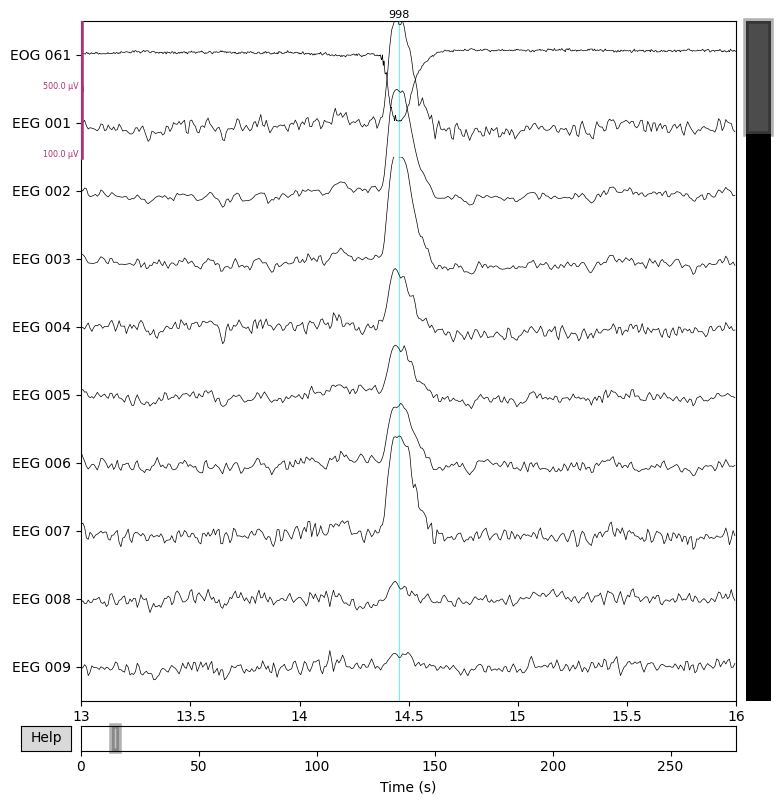

No projector specified for this dataset. Please consider the method self.add_proj.


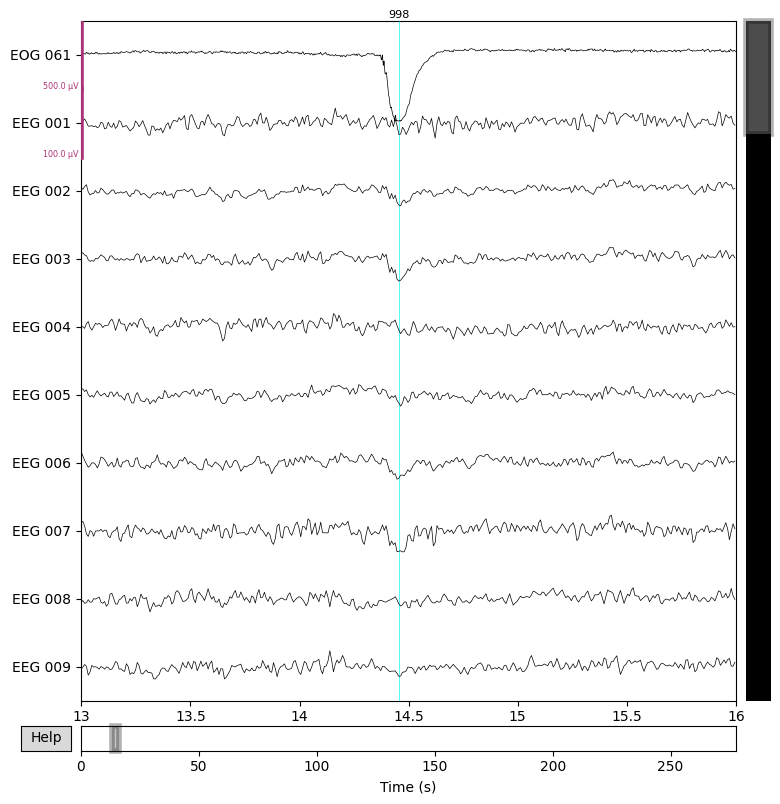

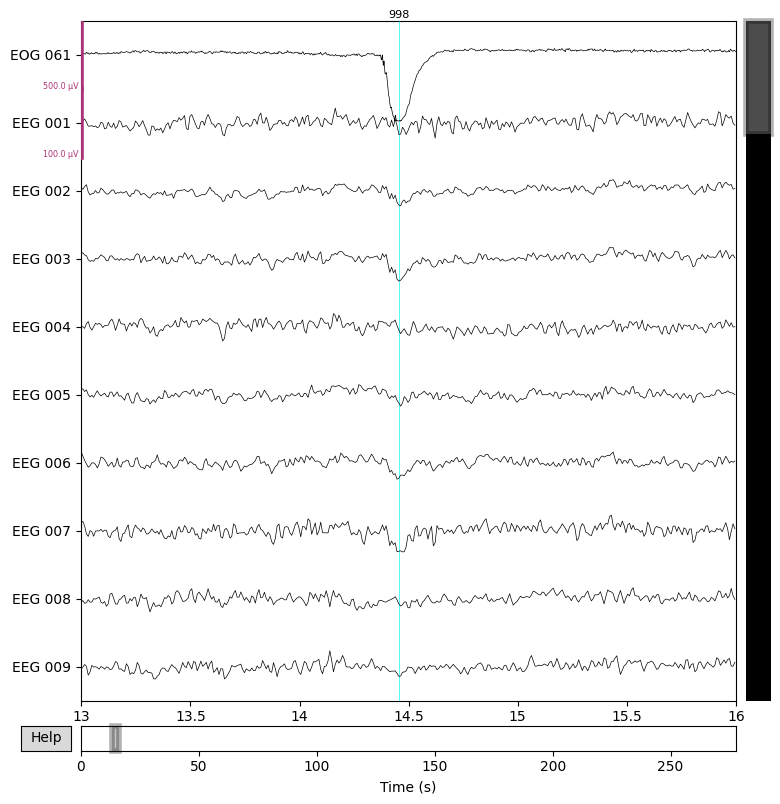

In [17]:
order = np.concatenate(
    [  # plotting order: EOG first, then EEG
        mne.pick_types(raw.info, meg=False, eog=True),
        mne.pick_types(raw.info, meg=False, eeg=True),
    ]
)
raw_kwargs = dict(
    events=eog_epochs.events,
    order=order,
    start=13,
    duration=3,
    n_channels=10,
    scalings=dict(eeg=50e-6, eog=250e-6),
)

# plot original data
raw.plot(**raw_kwargs)

# regress (using coefficients computed previously) and plot
raw_clean = model_evoked.apply(raw)
raw_clean.plot(**raw_kwargs)

## References
.. footbibliography::



In [18]:

are_same = np.array_equal(epochs_clean_plain, epochs_clean_sub)
print(are_same) 

False
